In [503]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy import special
import random

Some thoughts I had to make this script better are: use a better function to maximise - give efficiency more weighting perhaps even multiply the rabi function by (1-eff)^n or something like this.

Another thought would be to plot the efficiency and maximum Rabi difference with steps to see how things change with time and get a better idea of what is going on. + also plotting how the indices change with time would be interesting

Then, could also make this into a function so to just plug a load of stuff into to make it easier to use and quicker to get solutions to inputs.

And perhaps could even automate trying out different inputs and find out which one is the best.

This script determines the amplitudes for different tones depending on signals inputted into the EOM.
The aim is to work out these amplitudes for generic detuning factors. Then, with knowledge of the matrix elements for each transition, we will know what ratio we would like the amplitudes to take in order to have equal Rabi frequencies for each transition. Then, we can work backwards to find the modulation indices and thus the amplitudes of the electric fields for each modulating sine wave. These modulation indices should minimise the difference in Rabi frequency and maximise the efficiency.

This will initially only consider three modulating sine waves. This can be extended later on.

The maths an ideas for this code are written in OneNote.

In [504]:
#Define all of the frequencies we care about (we are working in MHz and are ignoring the 2pi for now to make things easy - also, frequencies are rounded) - these numbers don't actually matter.
#The setup is a bit difficult, so everything is carefully laid out:

DwG = 8000      #Ground state splitting
DwM = 60        #Metastable state splitting
Dw = 170.26e6   #Splitting between the lowest metastable state and the highest ground state

#Define where we have parked the laser relative to the 
Dw1 = 7000      #Where the unmodulated signal is sitting above the lowest ground state
Dw2 = 0       #Where the unmodulated signal is sitting above the lowest metastable state

#Define the frequency at which we have parked the beam
w = (DwG - Dw1) + Dw + Dw2

#Define the frequencies that we wish to find:
w1 = w - (DwG - Dw1) - Dw2
w2 = w - (DwG - Dw1) + (DwM - Dw2)
w3 = w + Dw1 - Dw2
w4 = w + Dw1 + (DwM - Dw2)

#Define the frequencies we wish to modulate at:
W = [(DwG - Dw1),Dw1,DwM]

In [505]:
#Work out how to make w1,w2,w3 and w4 using wm1,wm2 and wm3 from w. Consider only O orders.

Order = 3   #Considering up to the 2nd order.
values = range(-Order, Order + 1)  # from -Order to Order

Mod = []
#intertools produces all possible combinations of elements
for p in itertools.product(values, repeat = np.size(W)):     # this creates a list of all the possible combinations of each modulation frequency: we are making p a list rather than a tuple
    Mod.append(p)

#filter out all of the combinations that we won't use and create a list of all of the useful ones:
Combinations = []       #Define a list of all of the combinations for each frequency. Each component will be: [frequency that this adds up to, no. of W[0],...,no. of W[N]]
for list in Mod:

    #find the frequency when summing up the modulation frequencies as described by this component of Mod:
    freq = w
    for x in range(np.size(W)):
        freq += list[x] * W[x]

    #now, we want to see if this frequency is useful at all:
    if freq == w1:
        Combinations.append([1,list])
    if freq == w2:
        Combinations.append([2,list])
    if freq == w3:
        Combinations.append([3,list])
    if freq == w4:
        Combinations.append([4,list])

#so, now we should have a list of all of the useful combinations of the modulated frequencies:
print(Combinations)

[[1, (-1, 0, 0)], [2, (-1, 0, 1)], [3, (0, 1, 0)], [4, (0, 1, 1)]]


In [ ]:
#Define a function that outputs the amplitude for this sideband:
def A(list,ModIndices):
    
    A = 1
    for x in range(np.size(ModIndices)):
        A *= special.jv(list[x], ModIndices[x])
    return(A)

#Define a function to find the amplitudes for each of the frequencies
def FindAmps(Combinations,ModIndices):
    Amps = [0,0,0,0]

    for i in range(4):
        for x in Combinations:
            if x[0] == i+1:
                Amps[i] += A(x[1],ModIndices)

    #Make the amplitudes absolute since their signs no longer matter (no more intereference):
    return(np.abs(Amps))

In [ ]:
#Now, we have amplitudes but I assume that they are not what we want. We are starting from modulation indices defined at the top.
#We can use a bit of trial and error so that we can walk towards usable modulation indices.

#First of all, what is it that we want in the end? - set the matrix element for w1 to 1 and all of the others relative to this:
M = [1,1.1,1.2,0.9]


# this function finds the largest difference in the Rabi frequencies as a propotion of the mean of all of the Rabi frequencies
# also, for simplicity I have put the efficiency function in this as well so that we just have one function to run to get both
def DiffAndEff(Combinations,ModIndices,M):
    Amps = FindAmps(Combinations,ModIndices)

    mean = 0
    for x in range(np.size(M)):
        mean += Amps[x] * M[x]      #this adds up all of the Rabi frequencies
    mean /= np.size(M)              #then divide at the end to get the mean

    #now, find the largest difference:
    Diff = []

    for x in range(np.size(M)):
        Diff.append(np.abs(( Amps[0] * M[0] - Amps[x] * M[x] ) / mean ))  #to speed things up, we are just considering the difference between one of the Rabi frequencies and the others

    #find the maximum rabi freq out of all of these:
    MaxDiff = np.max(Diff)

    #also work out the efficiency:
    efficiency = 0
    for x in range(np.size(Amps)):
        efficiency += Amps[x] ** 2

    return(MaxDiff,efficiency)

In [ ]:
#define a function that takes the difference and efficiency and uses this to calculate the value of the function we wish to minimise - we want to minimise this function
def func(Diff, Eff, prop):
    func = Diff * (1 - Eff) ** prop
    return(func)

In [ ]:
#define a function that will work out the probability of taking a backwards step - a bit of randomness can help the system walk towards the lowest value of func
#an output of 1 is a yes and an output of 0 is a no. It is more probable to make a small step than it is to make a large step. Beta decides to what degree.
def choice(beta, func, Newfunc):
    prob = np.exp( beta * ( (func - Newfunc) / (0.5 * func + 0.5 * Newfunc))) # make this the mean so that as the function gets smaller, we still have random steps
    decision = random.choices([1 , 0] , [prob, 1-prob])
    return(decision[0])

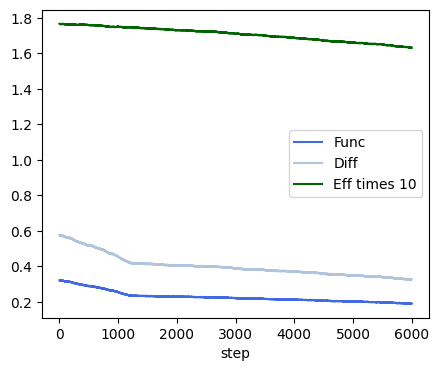

In [520]:
#Run the MCMC:
#The idea is to make a step towards the lower value of the function. If the step increases the function, it should only be taken with a small probablility.

#I want to start with big steps, then go to smaller steps:
#Start with increasing the first modulation index, then the second and so on, recording how this changes Diff, 
Diff_history = []
Eff_histroy = []
func_history = []
Index_history = []

#this is the step we will make between each calculation of the function
step = 0.001
#And beta determines how random our backwards steps may be
beta = 100          # a low beta means lots of randomness (high temp) and a high beta means less randomness (low temp)
#Have a variable that determines the proportion of how much we care for amplitude compared to matching Rabi Frequencies
prop = 3
#Define the modulation indices - later in the code, these will be used as initial guesses and changed to end up with what we want.
InitialModIndices = [1,1,1]
#number of iterations
N = 10**3
MaxDiff = 0.001

#define the function for the MCMC:
def MCMC(N,ModIndices,Combinations,M,prop,step):
    for i in range(0,N): 
        #start off with adding to modulation indices, then subtract.
        for sign in range(0,2):

            #see if changing the modulation index by a small step does anything, change F accordingly
            for x in range(np.size(ModIndices)):
                
                #make a copy of the indices, modified by the step
                NewModIndices = ModIndices.copy()
                NewModIndices[x] = NewModIndices[x] + ((-1) ** sign) * step

                #find the difference and efficiency for each
                Diff, Eff = DiffAndEff(Combinations,ModIndices,M)
                F = func(Diff, Eff, prop)

                NewDiff, NewEff = DiffAndEff(Combinations,NewModIndices,M)
                NewF = func(NewDiff, NewEff, prop)

                if NewF < F:
                    ModIndices = NewModIndices    #make the forwards step if we can
                    #save the new values (which may be the same as the old values)
                    func_history.append(NewF)
                    Diff_history.append(NewDiff)
                    Eff_histroy.append(NewEff)
                    Index_history.append(NewModIndices)
                
                else:
                    if choice(beta,F,NewF) == 1:
                        ModIndices = NewModIndices    #make a backwards step sometimes, with more probability if the step is small
                        #save the new values (which may be the same as the old values)
                        func_history.append(NewF)
                        Diff_history.append(NewDiff)
                        Eff_histroy.append(NewEff)
                        Index_history.append(NewModIndices)

                    else:
                        #save the new values (which may be the same as the old values)
                        func_history.append(F)
                        Diff_history.append(Diff)
                        Eff_histroy.append(Eff)
                        Index_history.append(ModIndices)

    return(Index_history,func_history,Diff_history,Eff_histroy)

Index_history,Func_history,Diff_history,Eff_history = MCMC(N,[1,1,1],Combinations,M,prop,step)

x = np.linspace(1,6*N,6*N)

###plotting data
plt.figure(figsize=(5,4))
plt.plot(x,Func_history, color='royalblue', label = 'Func')
plt.plot(x,Diff_history, color='lightsteelblue', label = 'Diff')
plt.plot(x,np.array(Eff_history)*10, color='darkgreen', label = 'Eff times 10')

plt.legend()
plt.xlabel('step')
plt.ylabel('')
plt.show()

In [ ]:



Index_history,func_history,Diff_history,Eff_history = MCMC_Variables(Order,W,M,[1,1,1],beta,prop,N)

this is very dependent on position, so I think it should be repeated for on a grid spacing and then the best should be found from this. - then can see how it compares with the brute force method

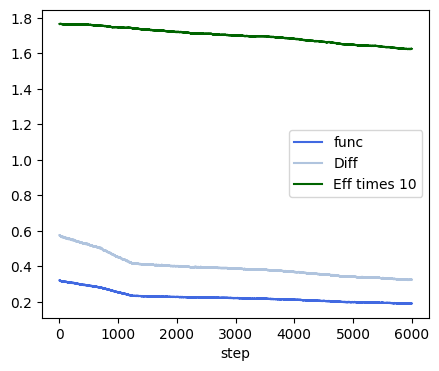

In [519]:
x = np.linspace(1,6*N,6*N)

###plotting data
plt.figure(figsize=(5,4))
plt.plot(x,func_history, color='royalblue', label = 'func')
plt.plot(x,Diff_history, color='lightsteelblue', label = 'Diff')
plt.plot(x,np.array(Eff_history)*10, color='darkgreen', label = 'Eff times 10')

plt.legend()
plt.xlabel('step')
plt.ylabel('')
plt.show()